In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sts
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)
inspector = inspect(engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

# Get column names to assist with queries
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
Station = Base.classes.station

# Get column names to assist with queries
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
max = engine.execute('SELECT MAX(DATE) FROM MEASUREMENT').fetchall()
max_date = max[0][0]
print("Most recent date in the dataset: ",max_date)

Most recent date in the dataset:  2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert max date to datetime, calculate -1 year, convert back into YYYY-MM-DD format for query

# ** THIS IS TO KEEP THE QUERY DYNAMIC IF THE DATABASE WERE TO GROW 
# ** WHILE REPORTING REQUIREMENTS REMAIN THE SAME
max_date_conv = datetime.strptime(max_date,'%Y-%m-%d' )
query_date = max_date_conv - dt.timedelta(days=365)
query_date_conv = query_date.strftime('%Y-%m-%d')

print("Query Date: >=", query_date_conv)

# Perform a query to retrieve the data and precipitation scores
precip=session.query(Measurement.date, Measurement.prcp).\
     filter(Measurement.date >= query_date_conv).\
     order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip,columns=['date','precipitation'])
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(['date'], ascending=True)
print(f"# of Records in precip_df before dropna: {len(precip_df)}")
precip_df = precip_df.dropna(how='any')
print(f"# of Records in precip_df after dropna: {len(precip_df)}")

Query Date: >= 2016-08-23
# of Records in precip_df before dropna: 2230
# of Records in precip_df after dropna: 2021


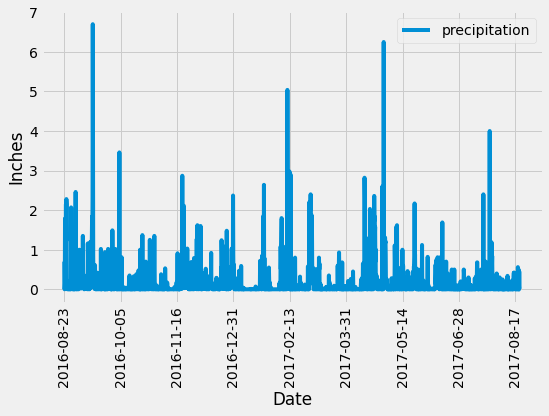

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(8,5))
plt.legend(loc="upper right")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

quartiles = precip_df['precipitation'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
# NOT DOING BELOW SINCE THIS RETURNS < 0 AND THERE ARE NO VALUES LESS THAN ZERO!
#print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

print('-'*50)

precip_l = precip_df['precipitation']
mean_numpy = np.mean(precip_l)
print(f"The mean of precipitation is {mean_numpy}")
median_numpy = np.median(precip_l)
print(f"The median of precipitation is {median_numpy}")
mode_scipy = sts.mode(precip_l)
print(f"The mode of precipitation is {mode_scipy}")
var_numpy = np.var(precip_l,ddof = 0)
print(f"The population variance using the NumPy module is {var_numpy}")

print('-'*50)

sd_numpy = np.std(precip_l,ddof = 0)
print(f"The population standard deviation using the NumPy module is {sd_numpy}")
print(f"Roughly 68% of the data is between {round(mean_numpy-sd_numpy,3)} and {round(mean_numpy+sd_numpy,3)}")
print(f"Roughly 95% of the data is between {round(mean_numpy-2*sd_numpy,3)} and {round(mean_numpy+2*sd_numpy,3)}")
print(f"Roughly 99.7% of the data is between {round(mean_numpy-3*sd_numpy,3)} and {round(mean_numpy+3*sd_numpy,3)}")
z_scipy = sts.zscore(precip_l)
print(f"The z-scores using the SciPy module are {z_scipy}")

The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values above 0.325 could be outliers.
--------------------------------------------------
The mean of precipitation is 0.17727857496288896
The median of precipitation is 0.02
The mode of precipitation is ModeResult(mode=array([0.]), count=array([874]))
The population variance using the NumPy module is 0.21259051566664736
--------------------------------------------------
The population standard deviation using the NumPy module is 0.4610753904370167
Roughly 68% of the data is between -0.284 and 0.638
Roughly 95% of the data is between -0.745 and 1.099
Roughly 99.7% of the data is between -1.206 and 1.561
The z-scores using the SciPy module are [ 1.13370055 -0.38448935 -0.05916294 ... -0.21098193 -0.38448935
 -0.38448935]


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset

engine.execute('SELECT COUNT(DISTINCT(MEASUREMENT.STATION)) FROM MEASUREMENT').fetchall()


[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
#engine.execute('SELECT STATION,COUNT(STATION) FROM STATION')group_by(.fetchall()

# List the stations and the counts in descending order.
# ** THIS IS TO KEEP THE QUERY DYNAMIC IF THE DATABASE WERE TO GROW 
# ** WHILE REPORTING REQUIREMENTS REMAIN THE SAME
most_active=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
most_active = most_active[0]
most_active

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


min=session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

max=session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

avg=session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

all=session.query(func.count(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

print(f"The lowest temperature for {most_active} is {min[0][0]}")
print(f"The hightest temperature for {most_active} is {max[0][0]}")
print(f"The average temperature for {most_active} is {avg[0][0]}")
print(f"The number (count) of readings for {most_active} is {all[0][0]}")

The lowest temperature for USC00519281 is 54.0
The hightest temperature for USC00519281 is 85.0
The average temperature for USC00519281 is 71.66378066378067
The number (count) of readings for USC00519281 is 2772


In [20]:
# Get the max date since this station's max date may not be the same as what
#  was queried earlier
max_date=session.query(func.max(Measurement.date)).\
    filter(Measurement.station == most_active).all()
max_date = max_date[0][0]


# Convert max date to datetime, calculate -1 year, convert back into YYYY-MM-DD format for query
# ** THIS IS TO KEEP THE QUERY DYNAMIC IF THE DATABASE WERE TO GROW 
# ** WHILE REPORTING REQUIREMENTS REMAIN THE SAME
max_date_conv = datetime.strptime(max_date,'%Y-%m-%d' )
query_date = max_date_conv - dt.timedelta(days=365)
query_date_conv = query_date.strftime('%Y-%m-%d')

print(f"Most Recent Date for station {most_active}:", max_date)
print("Query Date: >=", query_date_conv)


Most Recent Date for station USC00519281: 2017-08-18
Query Date: >= 2016-08-18


# of Records in temp_df before dropna: 357
# of Records in temp_df after dropna: 357


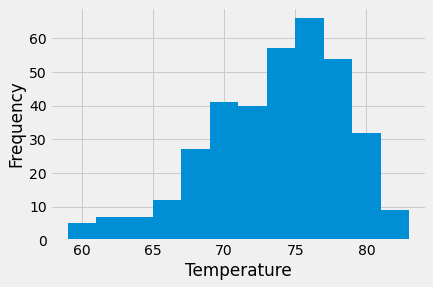

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_12mo=session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active).\
    filter(Measurement.date >= query_date_conv).all()
temp_df = pd.DataFrame(most_active_12mo, columns=['date','temperature'])
temp_df.set_index('date', inplace=True)

temp_df = temp_df.sort_values(['date'], ascending=True)
print(f"# of Records in temp_df before dropna: {len(temp_df)}")
temp_df = temp_df.dropna(how='any')
print(f"# of Records in temp_df after dropna: {len(temp_df)}")


plt.hist(temp_df, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [22]:
# Close Session
session.close()